In [1]:
import tensorflow as tf
import keras
from keras import datasets,models,layers
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()

In [3]:
x_train.shape

(50000, 32, 32, 3)

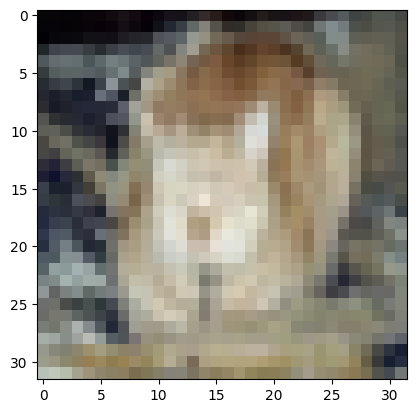

In [4]:
plt.imshow(x_train[33])

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,shuffle = True)

In [7]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train).toarray()
y_test = encoder.transform(y_test).toarray()
y_val =  encoder.transform(y_val).toarray()

In [8]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(x_train)

In [9]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model

In [10]:
class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_smaple = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)

        INIT_SCHEME = "he_normal"

        self.conv1 = Conv2D(self.__channels, 
                                strides=self.__strides[0], 
                                kernel_size=KERNEL_SIZE, 
                                padding="same", 
                                kernel_initializer=INIT_SCHEME)

        self.conv2 = Conv2D(self.__channels, 
                                strides=self.__strides[1], 
                                kernel_size=KERNEL_SIZE, 
                                padding="same", 
                                kernel_initializer=INIT_SCHEME)
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.merge = Add()

        if self.__down_smaple:

            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()
        
    def call(self, inputs):
        res = inputs
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.__down_smaple:
            res = self.res_conv(res)
            res = self.res_bn(res)
        
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out
        

In [11]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [12]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-09-13 14:50:08.354541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-13 14:50:08.354682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 74368     
 )                                                               
                                                         

In [14]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(x_train) / 256
history = model.fit(aug.flow(x_train,y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=30, validation_data=(x_train, y_train),callbacks=[es])

Epoch 1/30


2022-09-13 14:50:19.004715: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-13 14:50:20.109394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/156 [==============================] - ETA: 0s - loss: 1.6177 - accuracy: 0.4359

2022-09-13 14:50:38.246597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 23s 109ms/step - loss: 1.6177 - accuracy: 0.4359 - val_loss: 1.7134 - val_accuracy: 0.3874
Epoch 2/30
156/156 [==============================] - 15s 96ms/step - loss: 1.2399 - accuracy: 0.5537 - val_loss: 1.2314 - val_accuracy: 0.5630
Epoch 3/30
156/156 [==============================] - 15s 96ms/step - loss: 1.0759 - accuracy: 0.6135 - val_loss: 1.1705 - val_accuracy: 0.5870
Epoch 4/30
156/156 [==============================] - 15s 95ms/step - loss: 0.9642 - accuracy: 0.6573 - val_loss: 1.1221 - val_accuracy: 0.6140
Epoch 5/30
156/156 [==============================] - 15s 96ms/step - loss: 0.8749 - accuracy: 0.6923 - val_loss: 0.9663 - val_accuracy: 0.6601
Epoch 6/30
156/156 [==============================] - 15s 97ms/step - loss: 0.8038 - accuracy: 0.7191 - val_loss: 0.9406 - val_accuracy: 0.6652
Epoch 7/30
156/156 [==============================] - 15s 98ms/step - loss: 0.7398 - accuracy: 0.7395 - val_loss: 0.7952 - val_accuracy: 0.7246
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


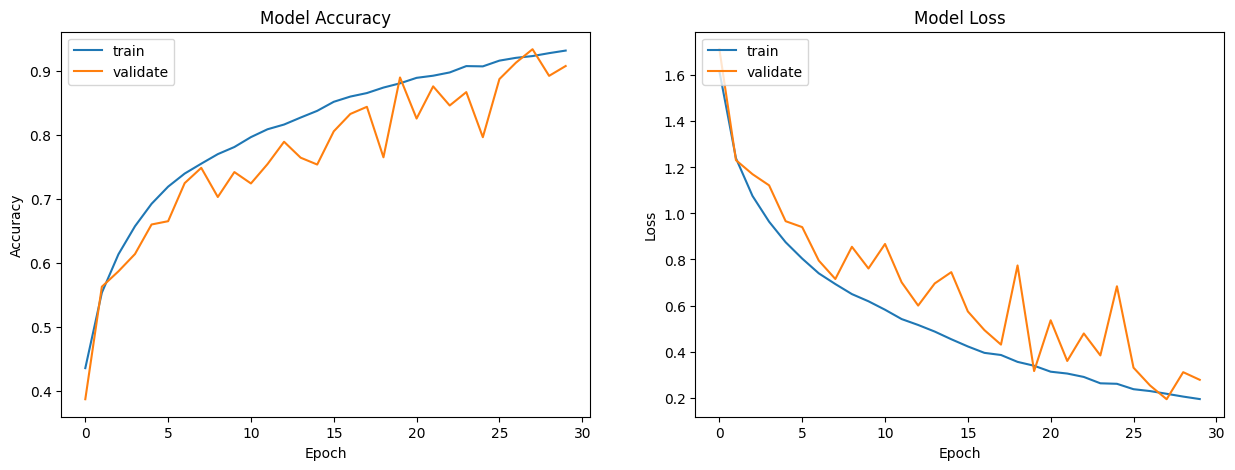

In [15]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)